# **Gaussian Process (GP) Implementations**

by Tomás Müller (U. Southampton - 2020)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as opt
import emcee

from scipy.interpolate import UnivariateSpline
import george
import celerite
import GPy
import torch
import gpytorch

sns.set(context='talk', style='white')
%config InlineBackend.figure_format = 'retina'

np.random.seed(1234)

First we will generate some data. This example was taken from the documentation of george.

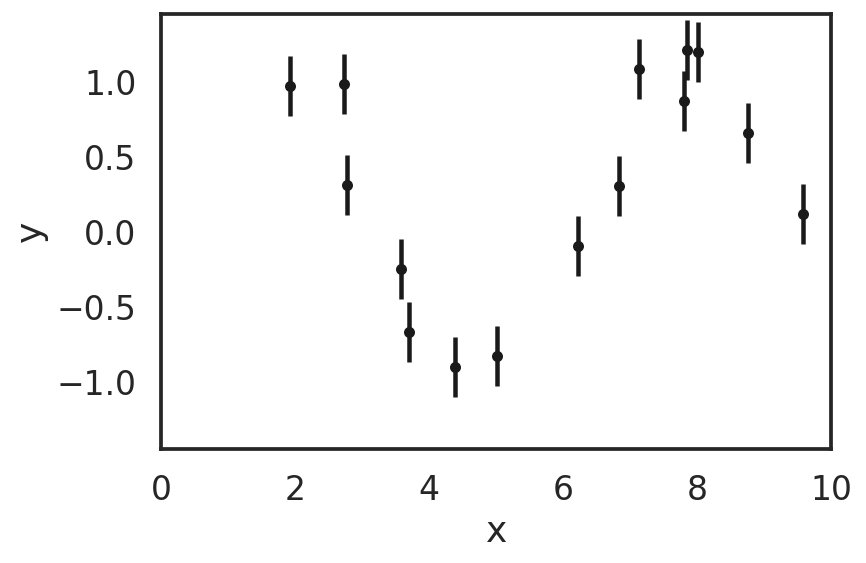

In [2]:
x = 10 * np.sort(np.random.rand(15))
yerr = 0.2 * np.ones_like(x)
y = np.sin(x) + yerr * np.random.randn(len(x))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

___
# Basic Implementation

In here I show the basic implementation of different GP packages. I include splines for reference as they are widely used in different works.

## Spline

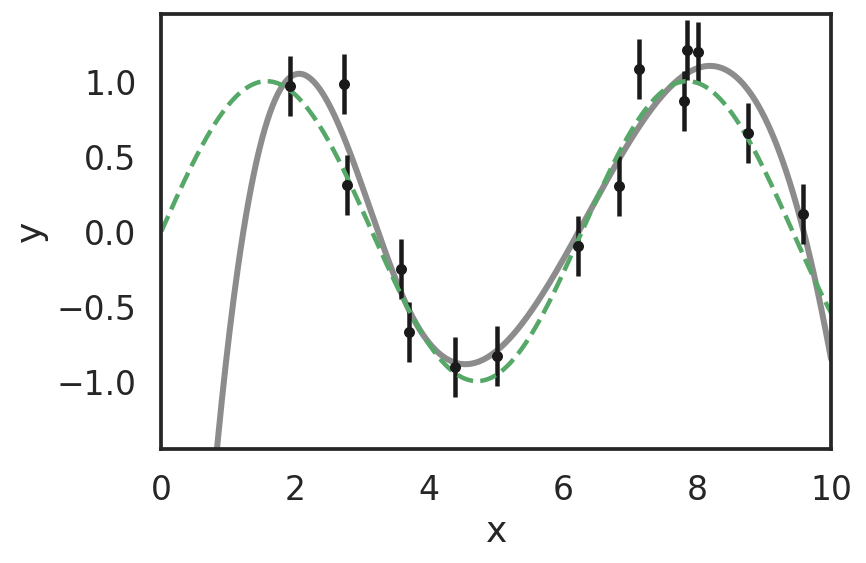

In [3]:
spl = UnivariateSpline(x, y, w=1/yerr, )
x_pred = np.linspace(0, 10, 500)
pred = spl(x_pred)

plt.plot(x_pred, pred, 'k', lw=3, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## george

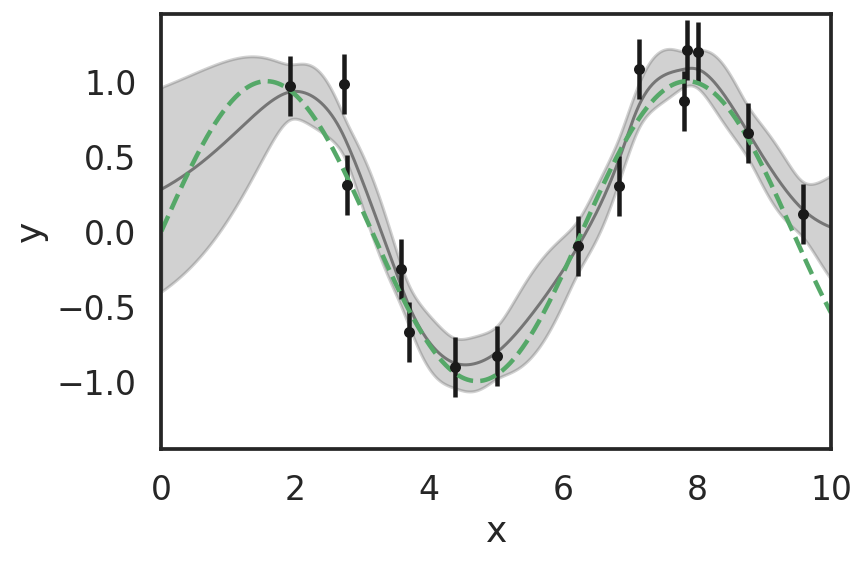

In [4]:
#kernel = np.var(y) * george.kernels.ExpSquaredKernel(2)
kernel = np.var(y) * george.kernels.Matern32Kernel(2)
gp = george.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## celerite

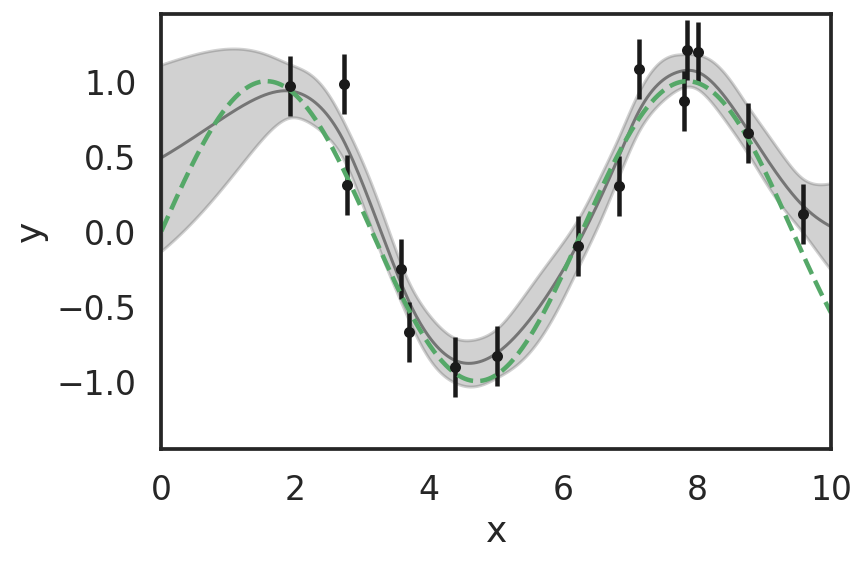

In [5]:
#Q, w0 = 1/np.sqrt(2), 0.5
#S0 = np.var(y) / (w0 * Q)
#log_S0, log_Q, log_omega0 = np.log(S0), np.log(Q), np.log(w0)
#kernel =  celerite.terms.SHOTerm(log_S0=log_S0, log_Q=log_Q, log_omega0=log_omega0)  # alternative to squared-exp. kernel
kernel = celerite.terms.Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(2), eps=1e-9)
gp = celerite.GP(kernel)
gp.compute(x, yerr)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## sklearn

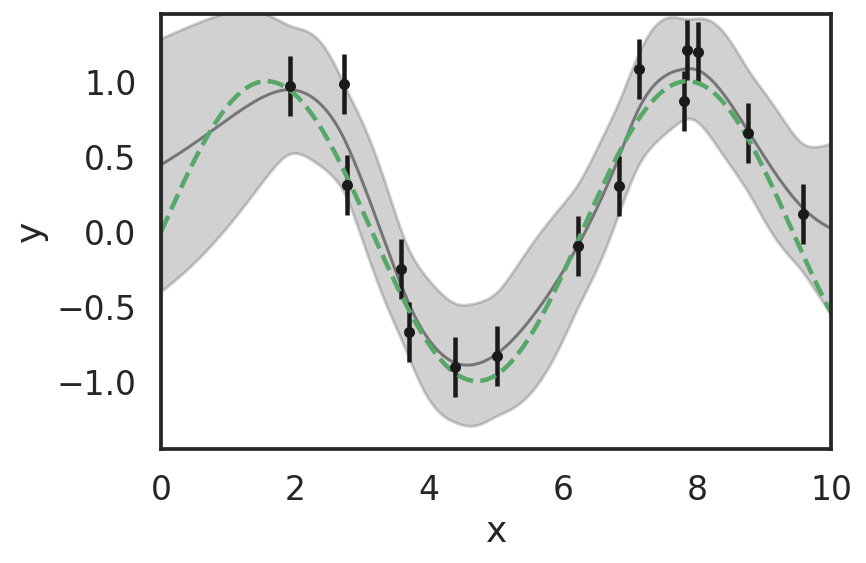

In [34]:
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = np.var(y) * Matern(2, nu=1.5)
gp_skl = GaussianProcessRegressor(kernel,
                                  alpha=yerr**2,
                                  copy_X_train=False).fit(x[:, None], y)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp_skl.predict(x_pred[:,None], return_std=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## GPy

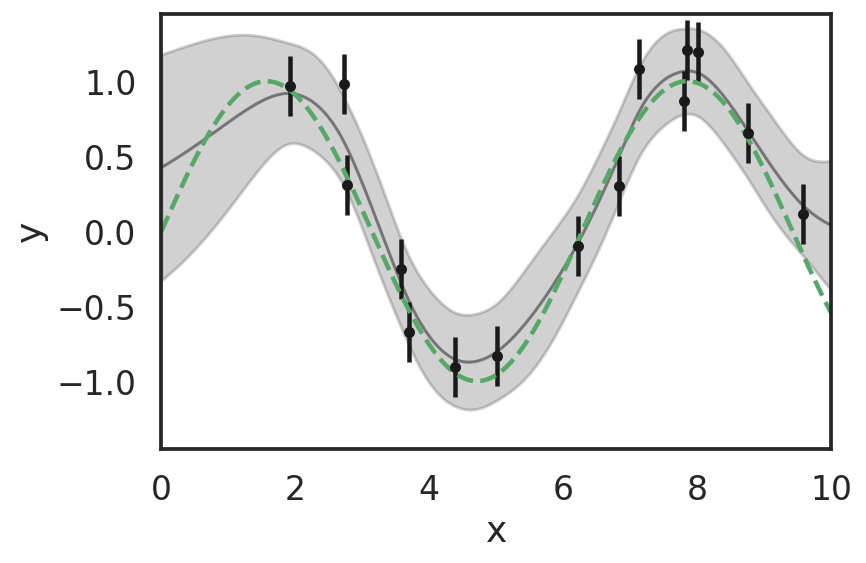

In [36]:
kernel = GPy.kern.Matern32(input_dim=1, variance=np.var(y), lengthscale=2)
model = GPy.models.GPRegression(x[:, None], y[:, None], kernel)
model['.*Gaussian_noise'] = yerr.mean()**2
model.randomize()
model.optimize()

x_pred = np.linspace(0, 10, 500)
pred, pred_var = model.predict(x_pred[:, None])
pred, pred_var = pred.flatten(), pred_var.flatten()

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## GPyTorch

 /home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:188: UserWarning:You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.


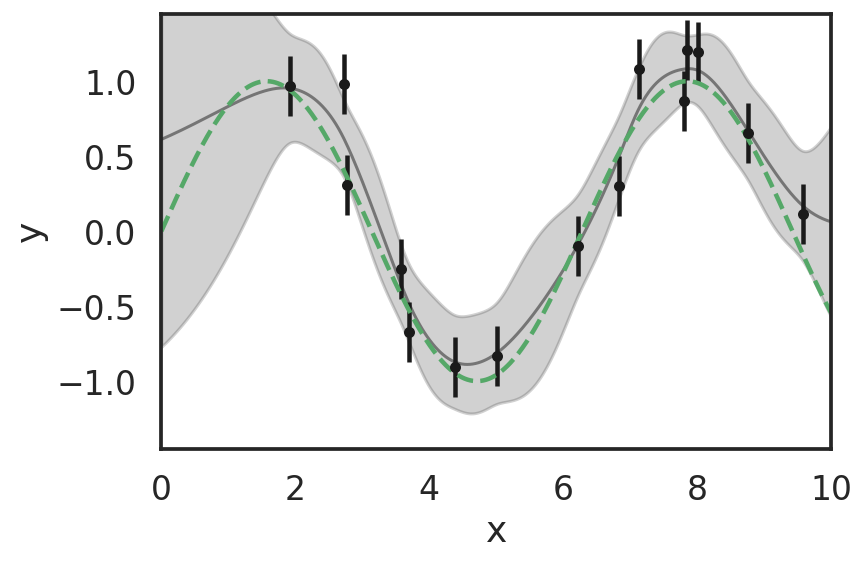

In [8]:
train_x = torch.from_numpy(x).type(dtype=torch.float32)
train_y = torch.from_numpy(y).type(dtype=torch.float32)
train_yerr = torch.from_numpy(yerr).type(dtype=torch.float32)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, train_yerr=0):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
    
    def forward(self, X):
        mean_X = self.mean_module(X)
        covar_X = self.covar_module(X)
        return gpytorch.distributions.MultivariateNormal(mean_X, covar_X)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(train_yerr**2)
model = ExactGPModel(train_x, train_y, likelihood, train_yerr)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_pred = torch.linspace(0, 10, 500)
    pred = likelihood(model(x_pred))    
    
# GP prediction
with torch.no_grad():
    lower, upper = pred.confidence_region()
    plt.fill_between(x_pred.numpy(), lower.numpy(), upper.numpy(),color="k", alpha=0.2)
    plt.plot(x_pred.numpy(), pred.mean.numpy(), "k", lw=1.5, alpha=0.5)

    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x_pred, np.sin(x_pred), "--g")
    plt.xlim(0, 10)
    plt.ylim(-1.45, 1.45)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

___
# Time Consumed

Below I check how long it takes to fit some data.

## Spline

In [9]:
%%timeit
spl = UnivariateSpline(x, y, w=1/yerr, )

144 µs ± 7.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## george (basic solver)

In [10]:
%%timeit
kernel = np.var(y) * george.kernels.Matern32Kernel(2)
gp = george.GP(kernel)
gp.compute(x, yerr)

508 µs ± 41.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## george (HODLR solver)
This solver is faster, but it can be less accurate

In [11]:
%%timeit
kernel = np.var(y) * george.kernels.Matern32Kernel(2)
gp = george.GP(kernel, solver=george.HODLRSolver)
gp.compute(x, yerr)

410 µs ± 9.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## celerite

This seems to be the fastest package

In [12]:
%%timeit
kernel = celerite.terms.Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(2), eps=1e-9)
gp = celerite.GP(kernel)
gp.compute(x, yerr)

260 µs ± 4.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## sklearn

In [13]:
%%timeit
kernel = np.var(y) * Matern(2, nu=1.5)
gp_skl = GaussianProcessRegressor(kernel,
                                  alpha=yerr**2,
                                  copy_X_train=False).fit(x[:, None], y)

11.9 ms ± 162 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## GPy

In [14]:
%%timeit
kernel = GPy.kern.Matern32(input_dim=1, variance=np.var(y), lengthscale=0.5)
model = GPy.models.GPRegression(x[:, None], y[:, None], kernel)
model['.*Gaussian_noise'] = yerr.mean()**2
model.randomize()
model.optimize()

30.3 ms ± 806 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## GPyTorch

This package takes much longer, but I think it works best for multi-D fits

In [15]:
%%timeit
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(train_yerr**2)
model = ExactGPModel(train_x, train_y, likelihood, train_yerr)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

202 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


___
# Advanced Modelling

In here I show more advance modelling with likelihood. This is easily done with `george` and `celerite`, I will not include the other packages for now. Optimization is done with `scipy`, but it could also be done with `emcee` (or other MCMC packages). Below is an example using the latter.

## george

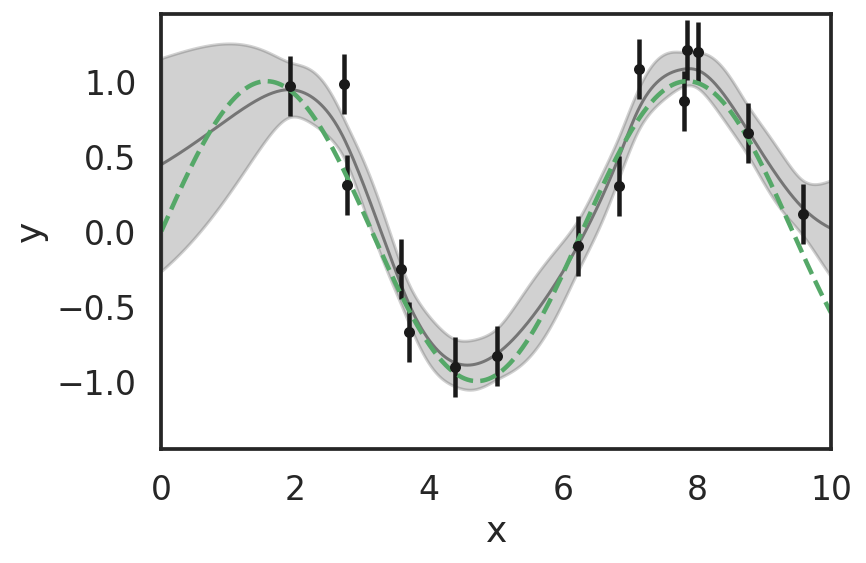

In [16]:
# Set up the GP model
kernel = np.var(y) * george.kernels.Matern32Kernel(2)
gp = george.GP(kernel)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return -np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = opt.minimize(neg_log_like, p0, jac=grad_neg_log_like, method="L-BFGS-B")

# Update the kernel
gp.set_parameter_vector(results.x)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## celerite

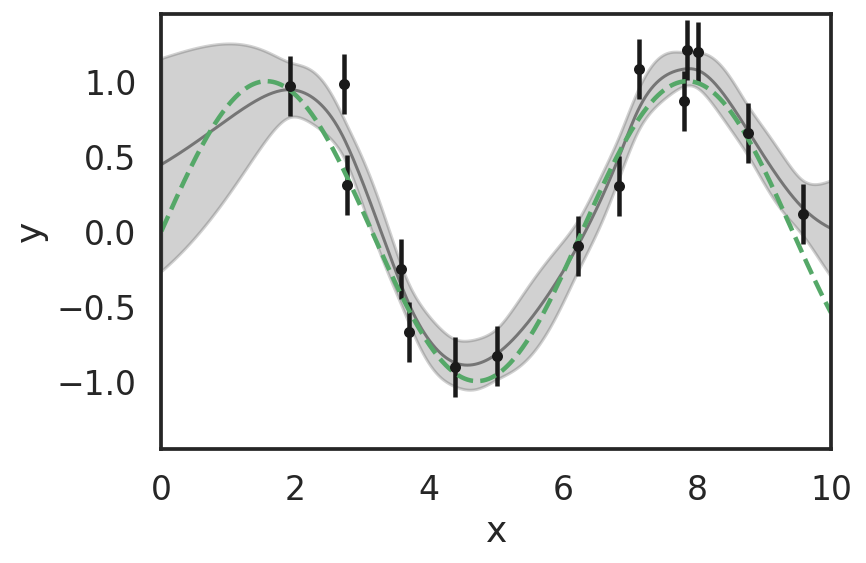

In [17]:
# Set up the GP model
kernel = celerite.terms.Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(2), eps=1e-9)
gp = celerite.GP(kernel)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return -np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)[1]

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = opt.minimize(neg_log_like, p0, jac=grad_neg_log_like, method="L-BFGS-B")

# Update the kernel
gp.set_parameter_vector(results.x)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## celerite + emcee

For some reason, `emcee` does not work great in this example...

Running burn-in...


 /home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/celerite/terms.py:566: RuntimeWarning:overflow encountered in double_scalars


Running production...


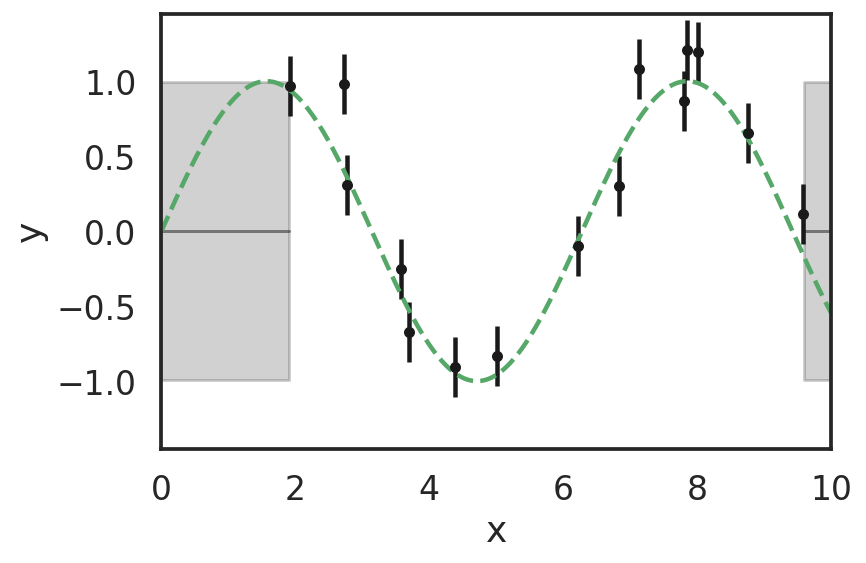

In [19]:
# Set up the GP model
kernel = celerite.terms.Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(2), eps=1e-9)
gp = celerite.GP(kernel)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return -np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)[1]

# Fit for the maximum likelihood parameters
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
results = opt.minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method="L-BFGS-B", bounds=bounds)

gp.set_parameter_vector(results.x)

# use emcee
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(y) + lp

initial = np.array(results.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 1000)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 3000);

samples = sampler.flatchain
opt_params = np.mean(samples, axis=0)
        
# Update the kernel
gp.set_parameter_vector(opt_params)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

___
# Advanced Modelling with Mean Function

This is the same as above, but with a mean function. This works for both `george` and `celerite`. I am not sure if something similar is possible with the other packages as I haven't tried them.

In this example I use a Gaussian as a mean function. This mean model was taken from the `celerite` documentation. A Gaussian is not a good mean model for this example, but it helps to understand how to build a more advanced GP model.

## george

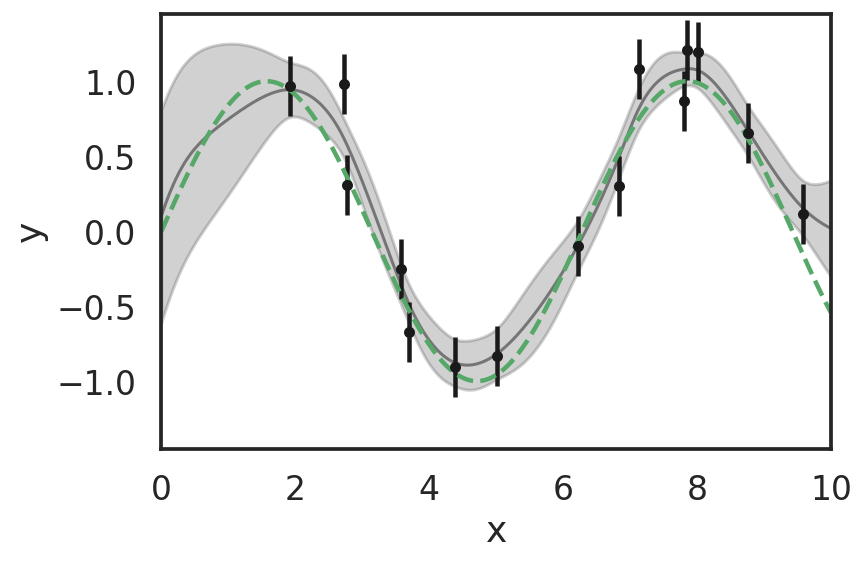

In [20]:
# Define the model
class MeanModel(george.modeling.Model):
    parameter_names = ("alpha", "ell", "log_sigma2")

    def get_value(self, t):
        return self.alpha * np.exp(-0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2))

    # This method is optional but it can be used to compute the gradient of the
    # cost function below.
    def compute_gradient(self, t):
        e = 0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2)
        dalpha = np.exp(-e)
        dell = self.alpha * dalpha * (t-self.ell) * np.exp(-self.log_sigma2)
        dlog_s2 = self.alpha * dalpha * e
        return np.array([dalpha, dell, dlog_s2])

mean_model = MeanModel(alpha=-1.0, ell=0.1, log_sigma2=np.log(0.4))

######################################################
# Set up the GP model
kernel = np.var(y) * george.kernels.Matern32Kernel(2)
gp = george.GP(kernel, mean=mean_model, fit_mean=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = opt.minimize(neg_log_like, p0, jac=grad_neg_log_like, method="L-BFGS-B")

# Update the kernel
gp.set_parameter_vector(results.x)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

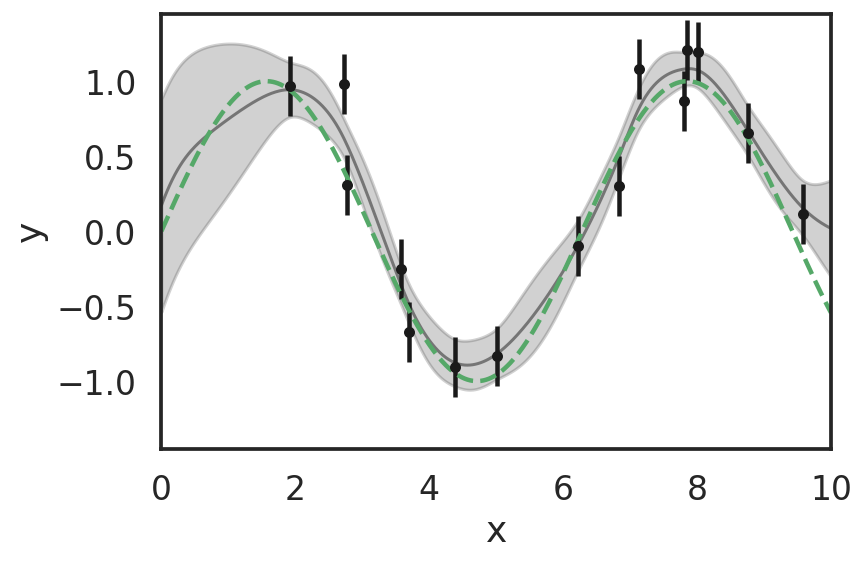

In [21]:
# Define the model
class MeanModel(celerite.modeling.Model):
    parameter_names = ("alpha", "ell", "log_sigma2")

    def get_value(self, t):
        return self.alpha * np.exp(-0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2))

    # This method is optional but it can be used to compute the gradient of the
    # cost function below.
    def compute_gradient(self, t):
        e = 0.5*(t-self.ell)**2 * np.exp(-self.log_sigma2)
        dalpha = np.exp(-e)
        dell = self.alpha * dalpha * (t-self.ell) * np.exp(-self.log_sigma2)
        dlog_s2 = self.alpha * dalpha * e
        return np.array([dalpha, dell, dlog_s2])

mean_model = MeanModel(alpha=-1.0, ell=0.1, log_sigma2=np.log(0.4))

######################################################
# Set up the GP model
kernel = celerite.terms.Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(2), eps=1e-9)
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)[1]

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = opt.minimize(neg_log_like, p0, jac=grad_neg_log_like, method="L-BFGS-B")

# Update the kernel
gp.set_parameter_vector(results.x)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Further testing

Below I create a mean model by fitting a polynomial first

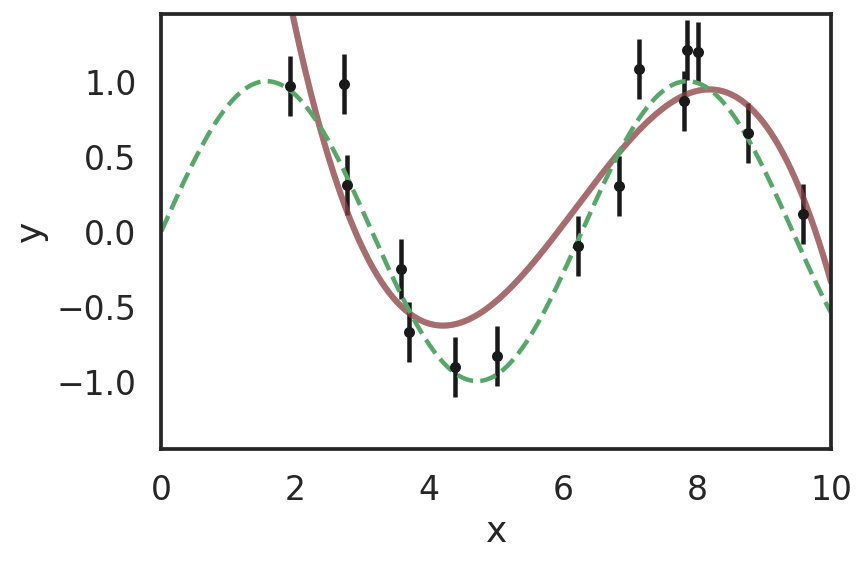

In [46]:
z = np.polyfit(x, y, 3)
poly = np.poly1d(z)

x_pred = np.linspace(0, 10, 500)
pred = poly(x_pred)
pred2 = poly.coeffs[3] + poly.coeffs[2]*x_pred + poly.coeffs[1]*x_pred**2 + poly.coeffs[0]*x_pred**3

plt.plot(x_pred, pred, 'k', lw=3, alpha=0.5)
plt.plot(x_pred, pred2, 'r', lw=3, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

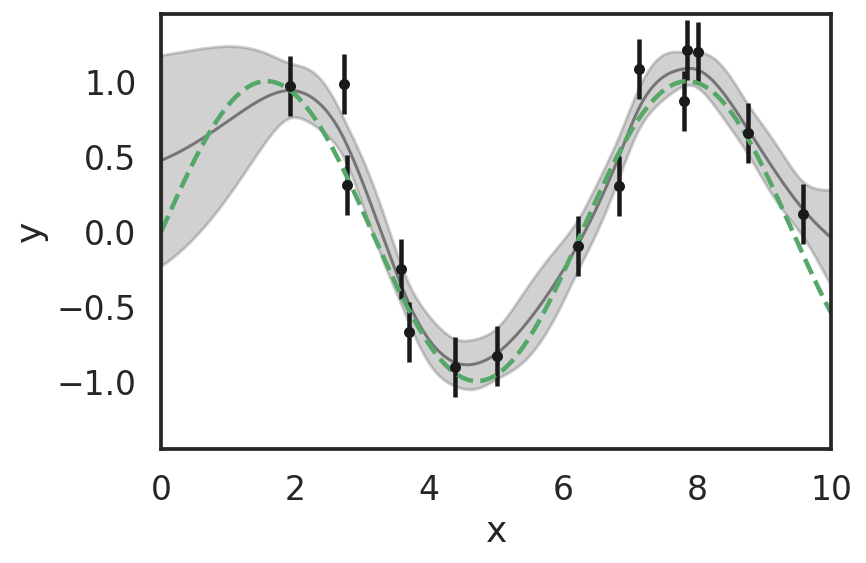

In [217]:
# Define the model
class MeanModel(celerite.modeling.Model):
    parameter_names = ("c1", "c2", "c3")

    def get_value(self, t):
        return self.c1*t + self.c2*t**2 + self.c3*t**3

    # compute_gradient does not work with constants,
    # hence, c0 is not included in the mean model
    def compute_gradient(self, t):
        dc1 = t
        dc2 = t**2
        dc3 = t**3
        return np.array([dc1, dc2, dc3])

z = np.polyfit(x, y, 3)
poly = np.poly1d(z)
c1, c2, c3 = poly.coeffs[2], poly.coeffs[1], poly.coeffs[0]
mean_model = MeanModel(c1=c1, c2=c2, c3=c3)

######################################################
# Set up the GP model
std, length = np.std(y), np.diff(x).max()
bounds_std = bounds_length = (np.log(1e-3), np.log(1e2))
bounds_c = (1e-6, np.inf)
bounds={"log_sigma":bounds_std, "log_rho":bounds_length, 
       "c1":bounds_c}

kernel = celerite.terms.Matern32Term(log_sigma=np.log(std), log_rho=np.log(length), eps=1e-9, bounds=bounds)
gp = celerite.GP(kernel, mean=mean_model, fit_mean=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x, yerr)

# Define a cost function
def neg_log_like(params):
    gp.set_parameter_vector(params)
    log_like = gp.log_likelihood(y, quiet=True)
    if np.isfinite(log_like):
        return -log_like
    else:
        return -np.inf

# Gradient of the cost function
def grad_neg_log_like(params):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y, quiet=True)[1]

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = opt.minimize(neg_log_like, p0, jac=grad_neg_log_like, method="L-BFGS-B")

# Update the kernel
gp.set_parameter_vector(results.x)

x_pred = np.linspace(0, 10, 500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# GP prediction
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x_pred, np.sin(x_pred), "--g")
plt.xlim(0, 10)
plt.ylim(-1.45, 1.45)
plt.xlabel("x")
plt.ylabel("y")
plt.show()